# Dataset Preparation

In [7]:
!pip install ucimlrepo

In [8]:
import pandas as pd
from ucimlrepo import fetch_ucirepo

# --- Fetch the dataset using its unique UCI ID (165) ---
concrete_compressive_strength = fetch_ucirepo(id = 165)

# --- Access the data as separate DataFrames ---
# X contains the features (input variables)
X = concrete_compressive_strength.data.features
# y contains the target (output variable: Concrete compressive strength)
y = concrete_compressive_strength.data.targets

# --- Combine X and y into a single DataFrame for easy viewing/manipulation ---
df = pd.concat([X, y], axis = 1)

# Neural Network Approximation

### Experiments S1-S4 (Four Data Sets)

Fetching Concrete Compressive Strength dataset...
Original X shape: (1030, 8), y shape: (1030, 1)

--- Four 25% Subsets Created ---
Set A (25%) X shape: (257, 8), y shape: (257, 1)
Set B (25%) X shape: (258, 8), y shape: (258, 1)
Set C (25%) X shape: (257, 8), y shape: (257, 1)
Set D (25%) X shape: (258, 8), y shape: (258, 1)


#############################################
### Starting 4-Fold Cross-Validation Loop ###
#############################################

--- EXPERIMENT 1/4 ---
Training Sets: ['B', 'C', 'D'] (Shape: torch.Size([773, 8]))
Test Set: [A] (Shape: torch.Size([257, 8]))

Starting model training...
Epoch 500/3000, Loss: 0.019651
Epoch 1000/3000, Loss: 0.010753
Epoch 1500/3000, Loss: 0.033780
Epoch 2000/3000, Loss: 0.009705
Epoch 2500/3000, Loss: 0.008663
Epoch 3000/3000, Loss: 0.007644
Training finished.

--- Fold Results ---
Coefficient of Determination (R^2) on Training Sets: 0.8263
Coefficient of Determination (R^2) on Test Set: 0.8332
----------------------------

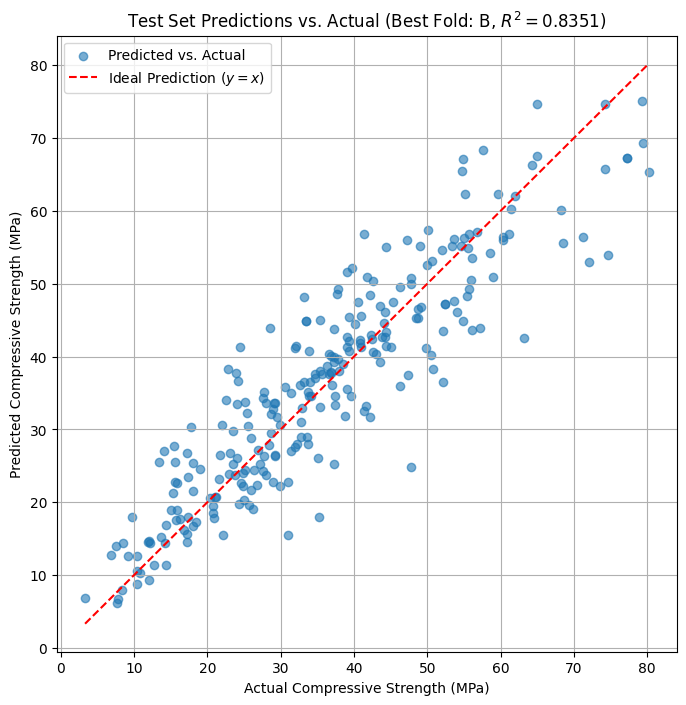

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from ucimlrepo import fetch_ucirepo
import numpy as np


# --- Fetch and Preprocess Data ---

def load_and_preprocess_data():
  """
  Fetches the Concrete Compressive Strength dataset, scales it, and
  splits it into four equal (25%) subsets labeled A, B, C, and D
  """
  print("Fetching Concrete Compressive Strength dataset...")
  concrete_compressive_strength = fetch_ucirepo(id = 165)

  # Data (as pandas dataframes)
  X = concrete_compressive_strength.data.features
  y = concrete_compressive_strength.data.targets

  # Target variable needs to be reshaped for consistent tensor operations
  y_vals = y.values.reshape(-1, 1)
  X_vals = X.values

  print(f"Original X shape: {X_vals.shape}, y shape: {y_vals.shape}")

  # Scaling/normalizing the 8 input features to a range between 0 and 1
  scaler_X = MinMaxScaler()
  X_scaled = scaler_X.fit_transform(X_vals)

  # The target output (value of compressive strength) also benefits from scaling
  scaler_y = MinMaxScaler()
  y_scaled = scaler_y.fit_transform(y_vals)

  # --- Step 1: Split 100% of the dataset into two 50% pools ---
  X_pool1, X_pool2, y_pool1, y_pool2 = train_test_split(X_scaled, y_scaled, test_size = 0.5, random_state = 42)

  # --- Step 2: Split Pool1 (50%) into Set A (25%) and Set B (25%) ---
  X_A, X_B, y_A, y_B = train_test_split(X_pool1, y_pool1, test_size = 0.5, random_state = 42)

  # --- Step 3: Split Pool2 (50%) into Set C (25%) and Set D (25%) ---
  X_C, X_D, y_C, y_D = train_test_split(X_pool2, y_pool2, test_size = 0.5, random_state = 42)

  # --- Print Shapes of the four 25% subsets ---
  print("\n--- Four 25% Subsets Created ---")
  print(f"Set A (25%) X shape: {X_A.shape}, y shape: {y_A.shape}")
  print(f"Set B (25%) X shape: {X_B.shape}, y shape: {y_B.shape}")
  print(f"Set C (25%) X shape: {X_C.shape}, y shape: {y_C.shape}")
  print(f"Set D (25%) X shape: {X_D.shape}, y shape: {y_D.shape}")

  # Convert NumPy arrays to PyTorch Tensors for all 8 components
  X_A_tensor = torch.tensor(X_A, dtype = torch.float32)
  y_A_tensor = torch.tensor(y_A, dtype = torch.float32)
  X_B_tensor = torch.tensor(X_B, dtype = torch.float32)
  y_B_tensor = torch.tensor(y_B, dtype = torch.float32)
  X_C_tensor = torch.tensor(X_C, dtype = torch.float32)
  y_C_tensor = torch.tensor(y_C, dtype = torch.float32)
  X_D_tensor = torch.tensor(X_D, dtype = torch.float32)
  y_D_tensor = torch.tensor(y_D, dtype = torch.float32)

  return (X_A_tensor, y_A_tensor, X_B_tensor, y_B_tensor, X_C_tensor, y_C_tensor, X_D_tensor, y_D_tensor, scaler_y)


# --- Neural Network Architecture ---

class Compressive_Strength(nn.Module):
  """
  A Feedforward Neural Network for predicting Concrete Compressive Strength

  The input layer is set to 8, matching the 8 input features (cement, age, etc.)
  """
  def __init__(self, input_size = 8, hidden_size = 8):
    super(Compressive_Strength, self).__init__()
    # Sets input size to 8, passes through 1 hidden layer
    self.hidden = nn.Linear(input_size, hidden_size)

    # Output layer remains 1 (compressive strength)
    self.output = nn.Linear(hidden_size, 1)

    # Tanh is used as the activation function since none is given
    self.activation = nn.Tanh()

  def forward(self, x):
    x = self.hidden(x)
    x = self.activation(x)

    # The output layer uses a linear activation
    x = self.output(x)
    return x


# --- Training Function ---

"""Trains the PyTorch model and tracks loss"""
def train(model, X_train, y_train, epochs = 3000, lr = 1.0):
  # Mean Squared Error (MSE) is the standard loss
  criterion = nn.MSELoss()
  # No optimizer is given, only the momentum factor
  optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.5)
  MAX_GRAD_NORM = 1.0

  print("\nStarting model training...")
  for epoch in range(1, epochs + 1):
    # Forward pass: compute predicted y by passing x to the model
    predictions = model(X_train)

    # Compute loss between predicted and true values
    loss = criterion(predictions, y_train)

    # Zero gradients, perform a backward pass, and update the weights based on loss
    optimizer.zero_grad()
    loss.backward()
    # Limits the size of the gradients so the model weights will not increase substantially from the large learning rate, lr = 1.0
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = MAX_GRAD_NORM)
    optimizer.step()

    if epoch % 500 == 0:
      print(f'Epoch {epoch}/{epochs}, Loss: {loss.item():.6f}')

  print("Training finished.")
  return model


# --- Evaluation Function ---

"""Evaluates the model on the training and test sets and calculates R^2 (coefficient of determination) for both"""
def evaluate(model, X_train, y_train, X_test, y_test, scaler_y):
  model.eval() # Set the model to evaluation mode
  with torch.no_grad():
    # --- Test Set R^2 Calculation ---
    predictions_scaled_test = model(X_test)
    predictions_mpa_test = scaler_y.inverse_transform(predictions_scaled_test.numpy())
    y_test_mpa = scaler_y.inverse_transform(y_test.numpy())
    test_r2 = r2_score(y_test_mpa, predictions_mpa_test)

    # --- Training Set R^2 Calculation ---
    predictions_scaled_train = model(X_train)
    predictions_mpa_train = scaler_y.inverse_transform(predictions_scaled_train.numpy())
    y_train_mpa = scaler_y.inverse_transform(y_train.numpy())
    train_r2 = r2_score(y_train_mpa, predictions_mpa_train)

    print(f"\n--- Fold Results ---")
    print(f"Coefficient of Determination (R^2) on Training Sets: {train_r2:.4f}")
    print(f"Coefficient of Determination (R^2) on Test Set: {test_r2:.4f}")

    return train_r2, test_r2


# --- Main Execution: 4-Fold Cross-Validation ---

if __name__ == '__main__':
  # Load and preprocess the data, retrieving the four subsets
  (X_A, y_A, X_B, y_B, X_C, y_C, X_D, y_D, scaler_y) = load_and_preprocess_data()

  # Combine the data subsets into a list of tuples for easy iteration
  data_sets = [
      ("A", X_A, y_A),
      ("B", X_B, y_B),
      ("C", X_C, y_C),
      ("D", X_D, y_D)
  ]

  # Storing both training and test R^2 results
  all_train_r2_results = []
  all_test_r2_results = []

  print("\n\n#############################################")
  print("### Starting 4-Fold Cross-Validation Loop ###")
  print("#############################################\n")

  # Four experiments: loop through each set to use it as the Test Set (4 folds)
  for i in range(len(data_sets)):
    test_set_label = data_sets[i][0]
    X_test = data_sets[i][1]
    y_test = data_sets[i][2]

    # The remaining 3 sets are the Training Sets
    training_sets = [data_sets[j] for j in range(len(data_sets)) if i != j]

    # Concatenate the training sets
    X_train_list = [set_data[1] for set_data in training_sets]
    y_train_list = [set_data[2] for set_data in training_sets]

    X_train = torch.cat(X_train_list, dim = 0)
    y_train = torch.cat(y_train_list, dim = 0)

    train_labels = [set_data[0] for set_data in training_sets]

    print(f"--- EXPERIMENT {i + 1}/4 ---")
    print(f"Training Sets: {train_labels} (Shape: {X_train.shape})")
    print(f"Test Set: [{test_set_label}] (Shape: {X_test.shape})")

    # 1. Instantiate a NEW model for each fold
    model = Compressive_Strength(input_size = X_train.shape[1], hidden_size = 8)

    # 2. Train the model
    trained_model = train(model, X_train, y_train, epochs = 3000, lr = 1.0)

    # 3. Evaluate the model (passing both train and test data)
    train_r2, test_r2 = evaluate(trained_model, X_train, y_train, X_test, y_test, scaler_y)
    all_train_r2_results.append(train_r2)
    all_test_r2_results.append(test_r2)
    print("---------------------------------------------\n")

  # --- Final Results Summary ---
  print("\n\n#############################################")
  print("### CROSS-VALIDATION SUMMARY (R^2) ###")
  print("#############################################")

  for i in range(len(data_sets)):
    print(f"Fold {i+1} (Test Set {data_sets[i][0]}):")
    print(f"  Train R^2 = {all_train_r2_results[i]:.4f}")
    print(f"  Test R^2  = {all_test_r2_results[i]:.4f}")

  avg_train_r2 = np.mean(all_train_r2_results)
  avg_test_r2 = np.mean(all_test_r2_results)

  print(f"\nAverage Train R^2 across all 4 Folds: {avg_train_r2:.4f}")
  print(f"Average Test R^2 across all 4 Folds: {avg_test_r2:.4f}")

# --- Plotting Visualization of Regression Plot ---
# Locating the experiment with the highest R^2
best_r2_index = np.argmax(all_test_r2_results)
best_test_r2 = all_test_r2_results[best_r2_index]
best_test_set_label = data_sets[best_r2_index][0]

print("\n\n#############################################")
print(f"### VISUALIZING FOLD WITH BEST TEST R^2 ###")
print(f"### Best Test R^2: {best_test_r2:.4f} (Test Set {best_test_set_label}) ###")
print("#############################################\n")

# Re-running the forward pass and inverse transform for the best test set
X_best_test = data_sets[best_r2_index][1]
y_best_test = data_sets[best_r2_index][2]

# Re-training and evaluating the best model to get its predictions
X_best_train_list = [set_data[1] for j, set_data in enumerate(data_sets) if j != best_r2_index]
y_best_train_list = [set_data[2] for j, set_data in enumerate(data_sets) if j != best_r2_index]
X_best_train = torch.cat(X_best_train_list, dim=0)
y_best_train = torch.cat(y_best_train_list, dim=0)

# Instantiating and train the best model again
best_model = Compressive_Strength(input_size = X_best_train.shape[1], hidden_size = 8)
trained_best_model = train(best_model, X_best_train, y_best_train, epochs = 3000, lr = 1.0)

# Getting predictions for the best test set
trained_best_model.eval()
with torch.no_grad():
  predictions_scaled_best_test = trained_best_model(X_best_test)

  # Inverse transform to get values in original MPa units
  predictions_mpa_best_test = scaler_y.inverse_transform(predictions_scaled_best_test.numpy()).flatten()
  y_best_test_mpa = scaler_y.inverse_transform(y_best_test.numpy()).flatten()

# Generating the scatter plot
try:
  import matplotlib.pyplot as plt

  plt.figure(figsize = (8, 8))
  plt.scatter(y_best_test_mpa, predictions_mpa_best_test, alpha = 0.6, label = 'Predicted vs. Actual')

  # Adding a line for perfect prediction (R^2 = 1)
  min_val = min(y_best_test_mpa.min(), predictions_mpa_best_test.min())
  max_val = max(y_best_test_mpa.max(), predictions_mpa_best_test.max())
  plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Prediction ($y=x$)')

  plt.title(f'Test Set Predictions vs. Actual (Best Fold: {best_test_set_label}, $R^2 = {best_test_r2:.4f}$)')
  plt.xlabel('Actual Compressive Strength (MPa)')
  plt.ylabel('Predicted Compressive Strength (MPa)')
  plt.grid(True)
  plt.legend()
  plt.show()

except ImportError:
  print("\nWarning: Matplotlib not found. Cannot generate plot.")
  print("Please install it: pip install matplotlib")
  print("Data for plot (Actual vs. Predicted MPa) is available in variables 'y_best_test_mpa' and 'predictions_mpa_best_test'.")

### Experiments R1-R4 (75-25 Training-Test Splits)

Fetching Concrete Compressive Strength dataset...
Original X shape: (1030, 8), y shape: (1030, 1)


#####################################################
### Starting Four Independent Random Experiments (R1-R4) ###
#####################################################

--- EXPERIMENT R1/4 ---
Training Set Shape: torch.Size([772, 8]), Test Set Shape: torch.Size([258, 8])

Starting model training...
Epoch 500/3000, Loss: 0.023000
Epoch 1000/3000, Loss: 0.014143
Epoch 1500/3000, Loss: 0.012053
Epoch 2000/3000, Loss: 0.011569
Epoch 2500/3000, Loss: 0.012384
Epoch 3000/3000, Loss: 0.011365
Training finished.

--- Experiment Results ---
Coefficient of Determination (R^2) on Training Set: 0.7372
Coefficient of Determination (R^2) on Test Set: 0.7358
--------------------------------------------------

--- EXPERIMENT R2/4 ---
Training Set Shape: torch.Size([772, 8]), Test Set Shape: torch.Size([258, 8])

Starting model training...
Epoch 500/3000, Loss: 0.049482
Epoch 1000/3000, Loss: 0.046704
E

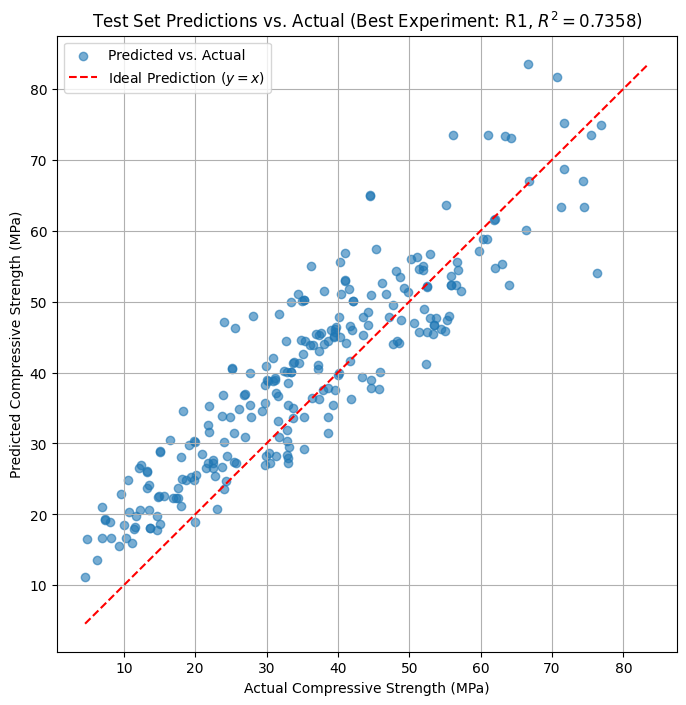

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from ucimlrepo import fetch_ucirepo
import numpy as np


# --- Fetch and Preprocess Data ---

def load_and_preprocess_data():
  """
  Fetches the Concrete Compressive Strength dataset, scales it, and
  returns the full scaled dataset as PyTorch tensors
  """
  print("Fetching Concrete Compressive Strength dataset...")
  concrete_compressive_strength = fetch_ucirepo(id = 165)

  # Data (as pandas dataframes)
  X = concrete_compressive_strength.data.features
  y = concrete_compressive_strength.data.targets

  # Target variable needs to be reshaped for consistent tensor operations
  y_vals = y.values.reshape(-1, 1)
  X_vals = X.values

  print(f"Original X shape: {X_vals.shape}, y shape: {y_vals.shape}")

  # Scaling for input features
  scaler_X = MinMaxScaler()
  X_scaled = scaler_X.fit_transform(X_vals)

  # Scaling for target output
  scaler_y = MinMaxScaler()
  y_scaled = scaler_y.fit_transform(y_vals)

  # Convert NumPy arrays to PyTorch Tensors
  X_full_tensor = torch.tensor(X_scaled, dtype = torch.float32)
  y_full_tensor = torch.tensor(y_scaled, dtype = torch.float32)

  return (X_full_tensor, y_full_tensor, scaler_y)


# --- Neural Network Architecture ---

class Compressive_Strength(nn.Module):
  """
  A Feedforward Neural Network for predicting compressive strength.
  """
  def __init__(self, input_size = 8, hidden_size = 8):
    super(Compressive_Strength, self).__init__()
    self.hidden = nn.Linear(input_size, hidden_size)
    self.output = nn.Linear(hidden_size, 1)
    self.activation = nn.ReLU()

  def forward(self, x):
    x = self.hidden(x)
    x = self.activation(x)

    x = self.output(x)
    return x


# --- Training Function ---

"""Trains the PyTorch model and tracks loss"""
def train(model, X_train, y_train, epochs = 3000, lr = 1.0):
  criterion = nn.MSELoss()
  optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.5)
  MAX_GRAD_NORM = 1.0

  print("\nStarting model training...")
  for epoch in range(1, epochs + 1):
    predictions = model(X_train)
    loss = criterion(predictions, y_train)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = MAX_GRAD_NORM)
    optimizer.step()

    if epoch % 500 == 0:
      print(f'Epoch {epoch}/{epochs}, Loss: {loss.item():.6f}')

  print("Training finished.")
  return model


# --- Evaluation Function ---

"""Evaluates the model on the training and test sets and calculates R^2 for both"""
def evaluate(model, X_train, y_train, X_test, y_test, scaler_y):
  model.eval()
  with torch.no_grad():
    # --- Test Set R^2 Calculation ---
    predictions_scaled_test = model(X_test)
    predictions_mpa_test = scaler_y.inverse_transform(predictions_scaled_test.numpy())
    y_test_mpa = scaler_y.inverse_transform(y_test.numpy())
    test_r2 = r2_score(y_test_mpa, predictions_mpa_test)

    # --- Training Set R^2 Calculation ---
    predictions_scaled_train = model(X_train)
    predictions_mpa_train = scaler_y.inverse_transform(predictions_scaled_train.numpy())
    y_train_mpa = scaler_y.inverse_transform(y_train.numpy())
    train_r2 = r2_score(y_train_mpa, predictions_mpa_train)

    print(f"\n--- Experiment Results ---")
    print(f"Coefficient of Determination (R^2) on Training Set: {train_r2:.4f}")
    print(f"Coefficient of Determination (R^2) on Test Set: {test_r2:.4f}")

    return train_r2, test_r2, predictions_scaled_test, y_test

if __name__ == '__main__':
  # Load the full, scaled dataset
  X_full, y_full, scaler_y = load_and_preprocess_data()

  # Storing both training and test R^2 results
  all_train_r2_results = []
  all_test_r2_results = []

  best_test_r2 = -1.0 # Initialize with a value lower than any expected R^2 (max is 1.0)
  best_experiment_label = "N/A" # Initialize with a default string
  best_predictions_scaled = None
  best_y_actual_scaled = None
  best_X_test = None
  best_y_test = None

  print("\n\n#####################################################")
  print("### Starting Four Independent Random Experiments (R1-R4) ###")
  print("#####################################################\n")

  # Four experiments: loop to create 4 random samples of training and testing sets
  for i in range(4):
    experiment_label = f"R{i + 1}"

    # Perform a NEW, random 75%-25% split for each experiment.
    # Use a unique random_state for reproducible, yet distinct, splits ("random_state")
    X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(X_full.numpy(), y_full.numpy(), test_size = 0.25, random_state = 42 + i)

    # Convert back to tensors
    X_train = torch.tensor(X_train_np, dtype = torch.float32)
    X_test = torch.tensor(X_test_np, dtype = torch.float32)
    y_train = torch.tensor(y_train_np, dtype = torch.float32)
    y_test = torch.tensor(y_test_np, dtype = torch.float32)

    print(f"--- EXPERIMENT {experiment_label}/4 ---")
    print(f"Training Set Shape: {X_train.shape}, Test Set Shape: {X_test.shape}")

    # 1. Instantiate a NEW model for each run
    model = Compressive_Strength(input_size=X_train.shape[1], hidden_size = 8)

    # 2. Train the model
    trained_model = train(model, X_train, y_train, epochs = 3000, lr = 1.0)

    # 3. Evaluate the model
    train_r2, test_r2, predictions_scaled_test, y_actual_scaled_test = evaluate(trained_model, X_train, y_train, X_test, y_test, scaler_y)
    all_train_r2_results.append(train_r2)
    all_test_r2_results.append(test_r2)

    # 4. Store data if this experiment has the best R^2 so far
    if test_r2 > best_test_r2:
      best_test_r2 = test_r2
      best_experiment_label = experiment_label
      # No need to re-train, just store the predictions and actuals from this evaluation
      best_predictions_scaled = predictions_scaled_test
      best_y_actual_scaled = y_actual_scaled_test
      # Store the current X_test and y_test for this best run
      best_X_test = X_test
      best_y_test = y_test
    print("--------------------------------------------------\n")

  # --- Final Results Summary ---
  print("\n\n#############################################")
  print("### INDEPENDENT EXPERIMENTS SUMMARY (R^2) ###")
  print("#############################################")

  for i in range(4):
    experiment_label = f"R{i + 1}"
    print(f"Experiment {experiment_label}:")
    print(f"  Train R^2 = {all_train_r2_results[i]:.4f}")
    print(f"  Test R^2  = {all_test_r2_results[i]:.4f}")

  avg_train_r2 = np.mean(all_train_r2_results)
  avg_test_r2 = np.mean(all_test_r2_results)

  print(f"\nAverage Train R^2 across all 4 Experiments: {avg_train_r2:.4f}")
  print(f"Average Test R^2 across all 4 Experiments: {avg_test_r2:.4f}")

  # --- Plotting Visualization of Regression Plot ---
  print("\n\n#############################################")
  print(f"### VISUALIZING EXPERIMENT WITH BEST TEST R^2 ###")
  print(f"### Best Test R^2: {best_test_r2:.4f} (Experiment {best_experiment_label}) ###")
  print("#############################################\n")

  try:
    # Inverse transform to get values in original MPa units
    # Use the stored predictions and actuals from the best experiment
    predictions_mpa_best_test = scaler_y.inverse_transform(best_predictions_scaled.numpy()).flatten()
    y_best_test_mpa = scaler_y.inverse_transform(best_y_actual_scaled.numpy()).flatten()

    plt.figure(figsize = (8, 8))
    plt.scatter(y_best_test_mpa, predictions_mpa_best_test, alpha = 0.6, label = 'Predicted vs. Actual')

    # Add a line for perfect prediction (R^2 = 1)
    min_val = min(y_best_test_mpa.min(), predictions_mpa_best_test.min())
    max_val = max(y_best_test_mpa.max(), predictions_mpa_best_test.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label = 'Ideal Prediction ($y=x$)')

    plt.title(f'Test Set Predictions vs. Actual (Best Experiment: {best_experiment_label}, $R^2 = {best_test_r2:.4f}$)')
    plt.xlabel('Actual Compressive Strength (MPa)')
    plt.ylabel('Predicted Compressive Strength (MPa)')
    plt.grid(True)
    plt.legend()
    plt.show()

  except Exception as e:
    print(f"\nWarning: Could not generate plot. An error occurred: {e}")
    print("Please ensure matplotlib is installed (`pip install matplotlib`) and your environment can display plots.")
    print("Data for plot (Actual vs. Predicted MPa) is available if you uncomment the relevant lines after the loop.")

# Nonlinear Regression Analysis

### Experiments S1-S4 (Four Data Sets)


--- Starting 4-Fold Cross-Validation (Water-to-Cement Ratio (w/c)) ---

--- Starting 4-Fold Cross-Validation (Water-to-Binder Ratio (w/b)) ---


*** RESULTS FOR WATER-TO-CEMENT RATIO (w/c) ***

--- 4-Fold Cross-Validation Results ---
|   Experiment | Test_Fold   |       a |       b |      c |      d |   R2_Train |   R2_Test |
|-------------:|:------------|--------:|--------:|-------:|-------:|-----------:|----------:|
|            1 | A           | 16.1524 | -0.6416 | 0.353  | 0.5692 |     0.6291 |    0.6306 |
|            2 | B           | 21.7135 | -0.6404 | 0.2655 | 0.4252 |     0.6293 |    0.6303 |
|            3 | C           | 22.6034 | -0.6635 | 0.2442 | 0.4243 |     0.6287 |    0.6317 |
|            4 | D           | 20.0863 | -0.6579 | 0.2794 | 0.4739 |     0.6325 |    0.6184 |

--- Average R^2 Values Across All Folds ---
Average R^2 (Training Sets): 0.6299
Average R^2 (Testing Sets): 0.6278


*** RESULTS FOR WATER-TO-BINDER RATIO (w/b) ***

--- 4-Fold Cross-Validation Result

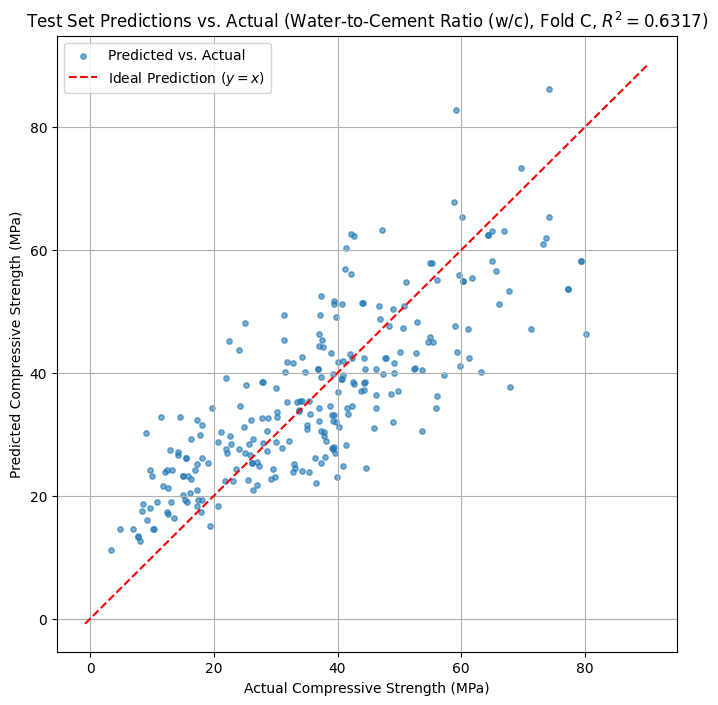

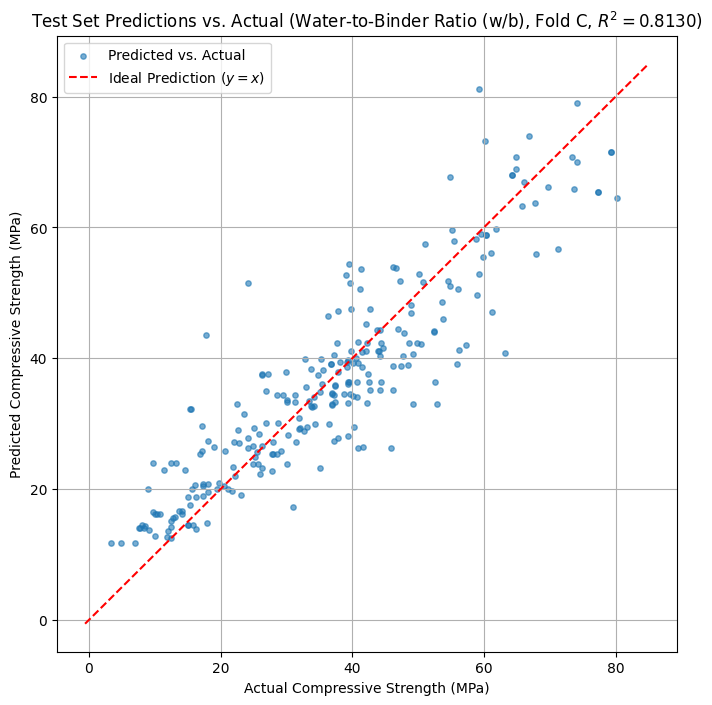

In [11]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from sklearn.model_selection import KFold
from ucimlrepo import fetch_ucirepo
import warnings
import matplotlib.pyplot as plt

# Suppress the UserWarning from ucimlrepo when loading the dataset
warnings.filterwarnings("ignore", category = UserWarning)

# --- Load Data (using ucimlrepo for reliability) ---
concrete_compressive_strength = fetch_ucirepo(id=165)
X_data = concrete_compressive_strength.data.features
y_data = concrete_compressive_strength.data.targets
raw_df = pd.concat([X_data, y_data], axis=1)

# Rename columns for standardization
raw_df.columns = [col.replace(' (component 1)', '').replace(' (component 2)', '').replace(' (component 3)', '').replace(' (component 4)', '').replace(' (component 5)', '').replace(' (component 6)', '').replace(' (component 7)', '').replace('(kg in a m^3 mixture)', '').replace('(day)', '').strip() for col in raw_df.columns]
raw_df.rename(columns={raw_df.columns[-1]: 'Strength', 'Cement (component 1)': 'Cement', 'Blast Furnace Slag (component 2)': 'Blast Furnace Slag', 'Fly Ash (component 3)': 'Fly Ash', 'Water (component 4)': 'Water', 'Age (day)': 'Age'}, inplace=True)


# --- Ratio Calculation Functions ---

def calculate_cement_ratio(df):
  """X = Water / Cement (W/C ratio)"""
  # Updated to Water / Cement
  return df['Water'] / df['Cement']

def calculate_binder_ratio(df):
  """X = Water / (Cement + Fly Ash + Blast Furnace Slag) (W/B ratio)"""
  # Updated to Water / Binder
  binder = df['Cement'] + df['Fly Ash'] + df['Blast Furnace Slag']
  return df['Water'] / binder


# --- Define the Non-Linear Model Function: f'c(t) = a * x^b * [(c * ln(t)) + d] ---
def concrete_model(data, a, b, c, d):
  """
  Non-linear regression function for concrete compressive strength
  data[:, 0] is the Ratio (x)
  data[:, 1] is the Age (t)
  """
  x = data[:, 0]
  t = data[:, 1]
  t = np.maximum(t, 1.0) # Ensure t >= 1 for np.log
  return a * (x**b) * (c * np.log(t) + d)


# --- Define the coefficient of determination, R^2 to calculate variance ---
def calculate_r_squared(y_true, y_pred):
  """Calculates the R^2 (Coefficient of Determination) metric"""
  ss_residual = np.sum((y_true - y_pred)**2)
  ss_total = np.sum((y_true - np.mean(y_true))**2)
  return 1 - (ss_residual / ss_total)


# --- Plotting Visualization of Regression Plot ---
def plot_best_fold(y_actual, y_predicted, ratio_type, r2_score, test_fold):
  try:
    plt.figure(figsize = (8, 8))
    plt.scatter(y_actual, y_predicted, alpha = 0.6, s=15, label = 'Predicted vs. Actual')

    # Add a line for perfect prediction (R^2 = 1)
    min_val = min(y_actual.min(), y_predicted.min())
    max_val = max(y_actual.max(), y_predicted.max())
    # Ensure a slight margin around the line
    margin = (max_val - min_val) * 0.05
    plot_range = [min_val - margin, max_val + margin]

    plt.plot(plot_range, plot_range, 'r--', label = 'Ideal Prediction ($y=x$)')

    plt.title(f'Test Set Predictions vs. Actual ({ratio_type}, Fold {test_fold}, $R^2 = {r2_score:.4f}$)')
    plt.xlabel('Actual Compressive Strength (MPa)')
    plt.ylabel('Predicted Compressive Strength (MPa)')
    plt.grid(True)
    plt.legend()
    plt.show()

  except Exception as e:
    print(f"\nWarning: Matplotlib error while plotting {ratio_type}: {e}")


# --- Main Experiment Function ---

def run_experiment(df_source, ratio_func, title_suffix):
  df = df_source.copy()
  df['Binder_Water_Ratio_x'] = ratio_func(df)

  # Select the features (X) and the target (y)
  X = df[['Binder_Water_Ratio_x', 'Age']].values
  y = df['Strength'].values

  # --- Set up Four-Fold Cross-Validation ---
  results = []
  # Initialize four-fold split mechanism (4 folds, shuffled, with fixed seed)
  kf = KFold(n_splits = 4, shuffle = True, random_state = 42) # Random state allows for repeatability through calling specific randomized training and testing sets
  fold_names = ['A', 'B', 'C', 'D']

  p0 = [20.0, 0.5, 1.0, 1.0] # Initial parameter (a, b, c, d) guesses
  lower_bounds = [0.001, -np.inf, -np.inf, 0.001] # Minimum allowable coefficient values
  MAX_FEV_LIMIT = 3000 # Maximum number of evaluations (similar to 3000 epochs)

  # Variables to store the data for the best test fold
  best_r2_test = -np.inf
  best_y_test = None
  best_y_test_pred = None
  best_test_fold_name = None

  print(f"\n--- Starting 4-Fold Cross-Validation ({title_suffix}) ---")

  # Loop through each fold split
  for i, (train_index, test_index) in enumerate(kf.split(X)):
    current_fold_name = fold_names[i]

    # Split the data based on KFold indices
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the non-linear model
    try:
      params, pcov = curve_fit(
        f = concrete_model,
        xdata = X_train,
        ydata = y_train,
        p0 = p0,
        bounds = (lower_bounds, np.inf),
        maxfev = MAX_FEV_LIMIT
      )
    except RuntimeError:
      params = [np.nan, np.nan, np.nan, np.nan]
      r2_train = np.nan
      r2_test = np.nan
      print(f"Experiment {i+1} (Test Fold: {current_fold_name}) failed to converge.")
    else:
      a_fit, b_fit, c_fit, d_fit = params

      # Predict and calculate R^2 for Training Set
      y_train_pred = concrete_model(X_train, *params)
      r2_train = calculate_r_squared(y_train, y_train_pred)

      # Predict and calculate R^2 for Testing Set
      y_test_pred = concrete_model(X_test, *params)
      r2_test = calculate_r_squared(y_test, y_test_pred)

      # Store best test result data
      if r2_test > best_r2_test:
        best_r2_test = r2_test
        best_y_test = y_test
        best_y_test_pred = y_test_pred
        best_test_fold_name = current_fold_name

    # Store results, recording the test fold name
    results.append({
      'Experiment': i + 1,
      'Test_Fold': current_fold_name,
      'a': a_fit,
      'b': b_fit,
      'c': c_fit,
      'd': d_fit,
      'R2_Train': r2_train,
      'R2_Test': r2_test
    })

  # Convert results list to DataFrame
  results_df = pd.DataFrame(results)

  # Calculate averages using the original float data (results list)
  avg_r2_train = pd.DataFrame(results)['R2_Train'].mean()
  avg_r2_test = pd.DataFrame(results)['R2_Test'].mean()

  # Apply the string formatting directly to the float columns
  float_cols = ['a', 'b', 'c', 'd', 'R2_Train', 'R2_Test']
  for col in float_cols:
    # Use the .4f format and explicitly convert the result to a string
    results_df[col] = results_df[col].apply(lambda x: f'{x:.4f}' if pd.notna(x) else 'NaN')
  results_df['Experiment'] = results_df['Experiment'].astype(pd.Int64Dtype())

  return results_df, avg_r2_train, avg_r2_test, best_y_test, best_y_test_pred, best_r2_test, best_test_fold_name


# --- EXECUTE BOTH EXPERIMENTS ---

# 1. Run for Water-to-Cement Ratio (w/c)
df_cement, avg_train_cement, avg_test_cement, best_y_cement, best_y_pred_cement, best_r2_cement, best_fold_cement = run_experiment(
  raw_df,
  calculate_cement_ratio,
  "Water-to-Cement Ratio (w/c)"
)

# 2. Run for Water-to-Binder Ratio (w/b)
df_binder, avg_train_binder, avg_test_binder, best_y_binder, best_y_pred_binder, best_r2_binder, best_fold_binder = run_experiment(
  raw_df,
  calculate_binder_ratio,
  "Water-to-Binder Ratio (w/b)"
)


# --- Final Output ---

# Table 1: w/c Ratio Results
print(f"\n\n*** RESULTS FOR WATER-TO-CEMENT RATIO (w/c) ***")
print("\n--- 4-Fold Cross-Validation Results ---")
print(df_cement.to_markdown(index = False))

print("\n--- Average R^2 Values Across All Folds ---")
print(f"Average R^2 (Training Sets): {avg_train_cement:.4f}")
print(f"Average R^2 (Testing Sets): {avg_test_cement:.4f}")

# Table 2: w/b Ratio Results
print(f"\n\n*** RESULTS FOR WATER-TO-BINDER RATIO (w/b) ***")
print("\n--- 4-Fold Cross-Validation Results ---")
print(df_binder.to_markdown(index = False))

print("\n--- Average R^2 Values Across All Folds ---")
print(f"Average R^2 (Training Sets): {avg_train_binder:.4f}")
print(f"Average R^2 (Testing Sets): {avg_test_binder:.4f}")

print("\n\n#############################################")
print("### GENERATING VISUALIZATIONS FOR BEST FOLDS ###")
print("#############################################")

try:
  # Plot the best fold for w/c Ratio
  plot_best_fold(
    best_y_cement,
    best_y_pred_cement,
    "Water-to-Cement Ratio (w/c)",
    best_r2_cement,
    best_fold_cement
  )

  # Plot the best fold for w/b Ratio
  plot_best_fold(
    best_y_binder,
    best_y_pred_binder,
    "Water-to-Binder Ratio (w/b)",
    best_r2_binder,
    best_fold_binder
  )

except NameError as e:
  print(f"\nFATAL ERROR: A variable was not defined. Did you run the execution lines? Error: {e}")
except Exception as e:
  print(f"\nFATAL PLOTTING ERROR: Could not generate plots. Please ensure matplotlib is installed. Error: {e}")


### Experiments R1-R4 (75-25 Training-Test Splits)



*** RESULTS FOR WATER-TO-CEMENT RATIO (w/c) ***

--- 4 Experiments (75%/25% Random Splits) Results ---
|   Experiment |   Random_State |       a |       b |      c |      d |   R2_Train |   R2_Test |
|-------------:|---------------:|--------:|--------:|-------:|-------:|-----------:|----------:|
|            1 |             42 | 15.0495 | -0.6416 | 0.3789 | 0.6109 |     0.6291 |    0.6306 |
|            2 |             10 | 26.459  | -0.6672 | 0.2111 | 0.3567 |     0.6298 |    0.6285 |
|            3 |             20 | 21.9468 | -0.6311 | 0.2545 | 0.449  |     0.6275 |    0.6343 |
|            4 |             30 | 23.7611 | -0.652  | 0.2454 | 0.3686 |     0.6346 |    0.6142 |

--- Average R^2 Values Across All Splits ---
Average R^2 (Training Sets): 0.6303
Average R^2 (Testing Sets): 0.6269


*** RESULTS FOR WATER-TO-BINDER RATIO (w/b) ***

--- 4 Experiments (75%/25% Random Splits) Results ---
|   Experiment |   Random_State |       a |       b |      c |      d |   R2_Train |   R2_T

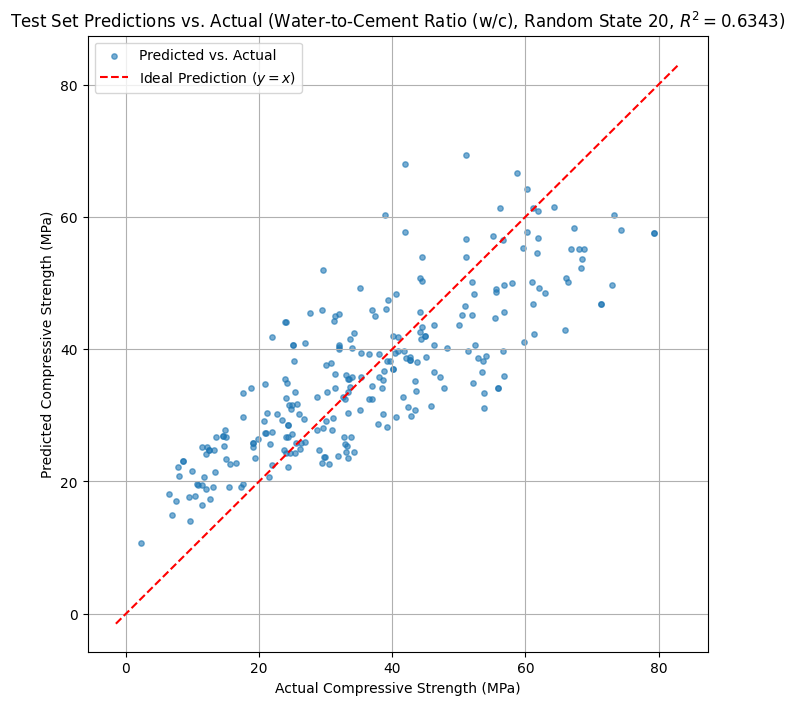

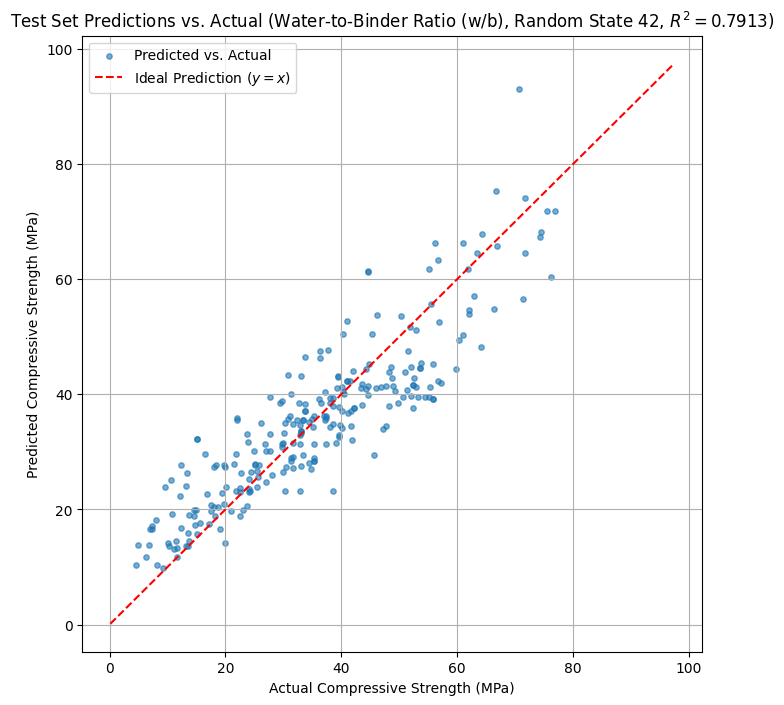

In [12]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split
from ucimlrepo import fetch_ucirepo
import warnings
import matplotlib.pyplot as plt

# Suppress the UserWarning from ucimlrepo when loading the dataset
warnings.filterwarnings("ignore", category=UserWarning)

# --- Load Data (using ucimlrepo for reliability) ---
concrete_compressive_strength = fetch_ucirepo(id=165)
X_data = concrete_compressive_strength.data.features
y_data = concrete_compressive_strength.data.targets
raw_df = pd.concat([X_data, y_data], axis=1)

# Rename columns for standardization
raw_df.columns = [col.replace(' (component 1)', '').replace(' (component 2)', '').replace(' (component 3)', '').replace(' (component 4)', '').replace(' (component 5)', '').replace(' (component 6)', '').replace(' (component 7)', '').replace('(kg in a m^3 mixture)', '').replace('(day)', '').strip() for col in raw_df.columns]
raw_df.rename(columns={raw_df.columns[-1]: 'Strength', 'Cement (component 1)': 'Cement', 'Blast Furnace Slag (component 2)': 'Blast Furnace Slag', 'Fly Ash (component 3)': 'Fly Ash', 'Water (component 4)': 'Water', 'Age (day)': 'Age'}, inplace=True)


# --- Ratio Calculation Functions ---

def calculate_cement_ratio(df):
  """X = Water / Cement (W/C ratio)"""
  return df['Water'] / df['Cement']

def calculate_binder_ratio(df):
  """X = Water / (Cement + Fly Ash + Blast Furnace Slag) (W/B ratio)"""
  binder = df['Cement'] + df['Fly Ash'] + df['Blast Furnace Slag']
  return df['Water'] / binder


# --- Define the Non-Linear Model Function: f'c(t) = a * x^b * [(c * ln(t)) + d] ---
def concrete_model(data, a, b, c, d):
  """
  Non-linear regression function for concrete compressive strength
  data[:, 0] is the Ratio (x)
  data[:, 1] is the Age (t)
  """
  x = data[:, 0]
  t = data[:, 1]
  t = np.maximum(t, 1.0) # Ensure t >= 1 for np.log
  return a * (x**b) * (c * np.log(t) + d)


# --- Define the Metric Function (R^2) ---
def calculate_r_squared(y_true, y_pred):
  """Calculates the R^2 (Coefficient of Determination) metric"""
  ss_residual = np.sum((y_true - y_pred)**2)
  ss_total = np.sum((y_true - np.mean(y_true))**2)
  return 1 - (ss_residual / ss_total)


# --- Plotting Visualization of Regression Plot ---
def plot_best_split(y_actual, y_predicted, ratio_type, r2_score, random_state):
  try:
    plt.figure(figsize = (8, 8))
    plt.scatter(y_actual, y_predicted, alpha = 0.6, s=15, label = 'Predicted vs. Actual')

    # Add a line for perfect prediction (R^2 = 1)
    min_val = min(y_actual.min(), y_predicted.min())
    max_val = max(y_actual.max(), y_predicted.max())
    margin = (max_val - min_val) * 0.05
    plot_range = [min_val - margin, max_val + margin]

    plt.plot(plot_range, plot_range, 'r--', label = 'Ideal Prediction ($y=x$)')

    plt.title(f'Test Set Predictions vs. Actual ({ratio_type}, Random State {random_state}, $R^2 = {r2_score:.4f}$)')
    plt.xlabel('Actual Compressive Strength (MPa)')
    plt.ylabel('Predicted Compressive Strength (MPa)')
    plt.grid(True)
    plt.legend()
    plt.show()

  except Exception as e:
    print(f"\nWarning: Matplotlib error while plotting {ratio_type}: {e}")


# --- Main Experiment Function ---

def run_experiment(df_source, ratio_func, title_suffix):
  df = df_source.copy()
  df['Water_Binder_Ratio_x'] = ratio_func(df)

  # Select the features (X) and the target (y)
  X = df[['Water_Binder_Ratio_x', 'Age']].values
  y = df['Strength'].values

  results = []
  p0 = [20.0, 0.5, 1.0, 1.0] # Initial parameter (a, b, c, d) guesses
  # Note: Bounds remain the same since the functional form f'c(t) is unchanged
  lower_bounds = [0.001, -np.inf, -np.inf, 0.001] # Minimum allowable values for coefficients
  MAX_FEV_LIMIT = 3000  # Maximum number of evaluations (similar to 3000 epochs)
  random_states = [42, 10, 20, 30] # Allows for repeatability by calling specific randomized training and testing sets

  best_r2_test = -np.inf
  best_y_test = None
  best_y_test_pred = None
  best_random_state = None

  for i in range(4):
    current_state = random_states[i]

    # Split the data into 75% Training and 25% Testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = current_state)

    # Fit the non-linear model
    try:
      params, pcov = curve_fit(
        f = concrete_model,
        xdata = X_train,
        ydata = y_train,
        p0 = p0,
        bounds = (lower_bounds, np.inf),
        maxfev = MAX_FEV_LIMIT
      )
    except RuntimeError:
      params = [np.nan, np.nan, np.nan, np.nan]
      r2_train = np.nan
      r2_test = np.nan
      print(f"Experiment {i+1} (Random State: {current_state}) failed to converge.")
    else:
      a_fit, b_fit, c_fit, d_fit = params

      # Predict and calculate R^2 for Training Set
      y_train_pred = concrete_model(X_train, *params)
      r2_train = calculate_r_squared(y_train, y_train_pred)

      # Predict and calculate R^2 for Testing Set
      y_test_pred = concrete_model(X_test, *params)
      r2_test = calculate_r_squared(y_test, y_test_pred)

      # --- Store best test result data ---
      if r2_test > best_r2_test:
        best_r2_test = r2_test
        best_y_test = y_test
        best_y_test_pred = y_test_pred
        best_random_state = current_state

    # Store results
    results.append({
      'Experiment': i + 1,
      'Random_State': current_state,
      'a': a_fit,
      'b': b_fit,
      'c': c_fit,
      'd': d_fit,
      'R2_Train': r2_train,
      'R2_Test': r2_test
    })

  # Convert results list to DataFrame
  results_df = pd.DataFrame(results)

  # --- Apply Formatting Fixes for Display ---

  # Apply the string formatting directly to the float columns
  float_cols = ['a', 'b', 'c', 'd', 'R2_Train', 'R2_Test']
  for col in float_cols:
    # Use the .4f format and explicitly convert the result to a string
    results_df[col] = results_df[col].apply(lambda x: f'{x:.4f}' if pd.notna(x) else 'NaN')
  results_df['Experiment'] = results_df['Experiment'].astype(pd.Int64Dtype())
  results_df['Random_State'] = results_df['Random_State'].astype(pd.Int64Dtype())

  # Calculate averages using the original float data (results list)
  avg_r2_train = pd.DataFrame(results)['R2_Train'].mean()
  avg_r2_test = pd.DataFrame(results)['R2_Test'].mean()

  return results_df, avg_r2_train, avg_r2_test, best_y_test, best_y_test_pred, best_r2_test, best_random_state


# --- EXECUTE BOTH EXPERIMENTS ---

# 1. Run for Water-to-Cement Ratio (w/c)
df_cement, avg_train_cement, avg_test_cement, best_y_cement, best_y_pred_cement, best_r2_cement, best_state_cement = run_experiment(
  raw_df,
  calculate_cement_ratio,
  "Water-to-Cement Ratio (w/c)"
)

# 2. Run for Water-to-Binder Ratio (w/b)
df_binder, avg_train_binder, avg_test_binder, best_y_binder, best_y_pred_binder, best_r2_binder, best_state_binder = run_experiment(
  raw_df,
  calculate_binder_ratio,
  "Water-to-Binder Ratio (w/b)"
)


# --- Final Output ---

# Table 1: w/c Ratio Results
print(f"\n\n*** RESULTS FOR WATER-TO-CEMENT RATIO (w/c) ***")
print("\n--- 4 Experiments (75%/25% Random Splits) Results ---")
print(df_cement.to_markdown(index = False))

print("\n--- Average R^2 Values Across All Splits ---")
print(f"Average R^2 (Training Sets): {avg_train_cement:.4f}")
print(f"Average R^2 (Testing Sets): {avg_test_cement:.4f}")

# Table 2: w/b Ratio Results
print(f"\n\n*** RESULTS FOR WATER-TO-BINDER RATIO (w/b) ***")
print("\n--- 4 Experiments (75%/25% Random Splits) Results ---")
print(df_binder.to_markdown(index = False))

print("\n--- Average R^2 Values Across All Splits ---")
print(f"Average R^2 (Training Sets): {avg_train_binder:.4f}")
print(f"Average R^2 (Testing Sets): {avg_test_binder:.4f}")

print("\n\n#####################################################")
print("### GENERATING VISUALIZATIONS FOR BEST RANDOM SPLITS ###")
print("#####################################################")

try:
  # Plot the best split for w/c Ratio
  plot_best_split(
    best_y_cement,
    best_y_pred_cement,
    "Water-to-Cement Ratio (w/c)",
    best_r2_cement,
    best_state_cement
  )

  # Plot the best split for w/b Ratio
  plot_best_split(
    best_y_binder,
    best_y_pred_binder,
    "Water-to-Binder Ratio (w/b)",
    best_r2_binder,
    best_state_binder
  )

except Exception as e:
  # This captures the case where matplotlib might not be installed or other runtime errors occur
  print(f"\nFATAL PLOTTING ERROR: Could not generate plots. Error: {e}")
  print("Please ensure matplotlib is installed (`pip install matplotlib`).")

Google. (2025). Concrete Strength Neural Network Code [Computer software]. Generated by Gemini.